# Müzik Türü Sınıflandırma Projesi

Bu notebook, FMA (Free Music Archive) veri setini kullanarak müzik türü sınıflandırma modeli geliştirmek için veri hazırlama ve dengeleme işlemlerini içermektedir.

## Gerekli Kütüphanelerin İçe Aktarılması
Aşağıdaki hücrede, projede kullanılacak temel Python kütüphaneleri import edilmektedir:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE
from collections import Counter

%matplotlib inline
sns.set(style='whitegrid')

## Yardımcı Fonksiyonlar

### Sınıf Dağılımı Görselleştirme Fonksiyonu
Aşağıdaki fonksiyon, veri setindeki sınıf dağılımlarını görselleştirmek için kullanılacaktır. Bu görselleştirme, veri dengesizliğini anlamamıza yardımcı olur.

In [2]:
def plot_class_distribution(y, labels, title):
    counts = pd.Series(y).value_counts().sort_index()
    valid_indices = counts.index[counts.index < len(labels)]
    counts = counts.loc[valid_indices]
    names = labels[counts.index]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=names, y=counts.values, hue=names, palette='viridis', legend=False)
    ax.set_title(title)
    ax.set_xlabel('Sınıf')
    ax.set_ylabel('Sayı')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Veri Yükleme ve Ön İşleme

Bu bölümdeki fonksiyon:
- FMA metadata dosyalarını yükler
- Gerekli sütunları seçer
- Eksik verileri temizler
- Etiketleri kodlar
- Veriyi sayısal formata dönüştürür

In [3]:
def load_data():
    tracks_path = 'fma_metadata/tracks.csv'
    features_path = 'fma_metadata/features.csv'

    if not os.path.exists(tracks_path) or not os.path.exists(features_path):
        raise FileNotFoundError(f"Gerekli veri dosyaları bulunamadı. '{tracks_path}' ve '{features_path}' dosyalarının mevcut olduğundan emin olun.")

    tracks = pd.read_csv(tracks_path, index_col=0, header=[0,1])
    
    features = pd.read_csv(features_path, index_col=0, header=[0,1])  # Çok seviyeli başlıkla oku
    features = features.loc[:, features.columns.get_level_values(0) != 'statistics']  # 'statistics' sütunlarını kaldır
    features = features.astype(np.float32)  # Sayısal olmayan sütunları kaldırdıktan sonra float'a dönüştür

    features.index = features.index.astype(str)
    tracks.index = tracks.index.astype(str)

    genre_series = tracks[('track', 'genre_top')].dropna()
    common_index = features.index.intersection(genre_series.index)

    X = features.loc[common_index]
    y_labels = genre_series.loc[common_index]

    X = X.fillna(0).replace([np.inf, -np.inf], 0).astype(np.float32)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)

    print('Veriler yüklendi ve önişlendi.')
    return X, y, label_encoder

## Başlangıç Veri Analizi

Verinin ilk yüklemesini yapıp, başlangıçtaki sınıf dağılımını inceleyelim. Bu analiz, veri dengesizliği problemini görselleştirmemize yardımcı olacak.

/tmp/ipykernel_23938/3123553461.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(features_path, index_col=0, header=[0,1])  # Çok seviyeli başlıkla oku


Veriler yüklendi ve önişlendi.


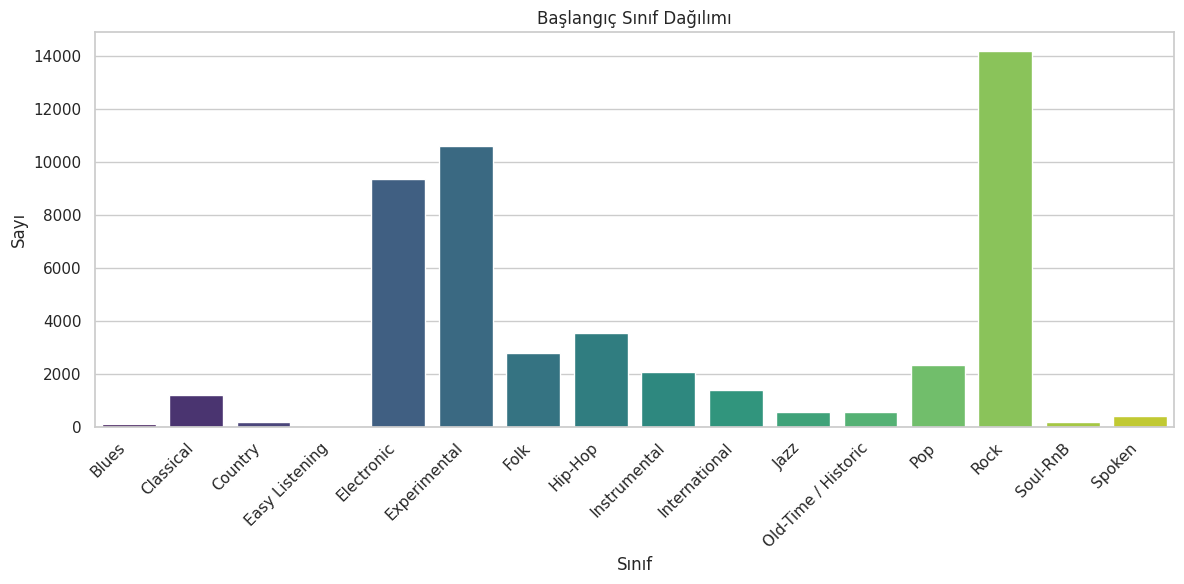

In [4]:
# Veriyi yükle ve önişle
X, y, le = load_data()

# Başlangıç dağılımını göster
plot_class_distribution(y, le.classes_, 'Başlangıç Sınıf Dağılımı')

## Veri Bölme ve Eğitim Seti Analizi

Veriyi eğitim ve test setlerine ayırıp, eğitim setindeki sınıf dağılımını inceliyoruz. Stratified split kullanarak orijinal dağılımı koruyoruz.

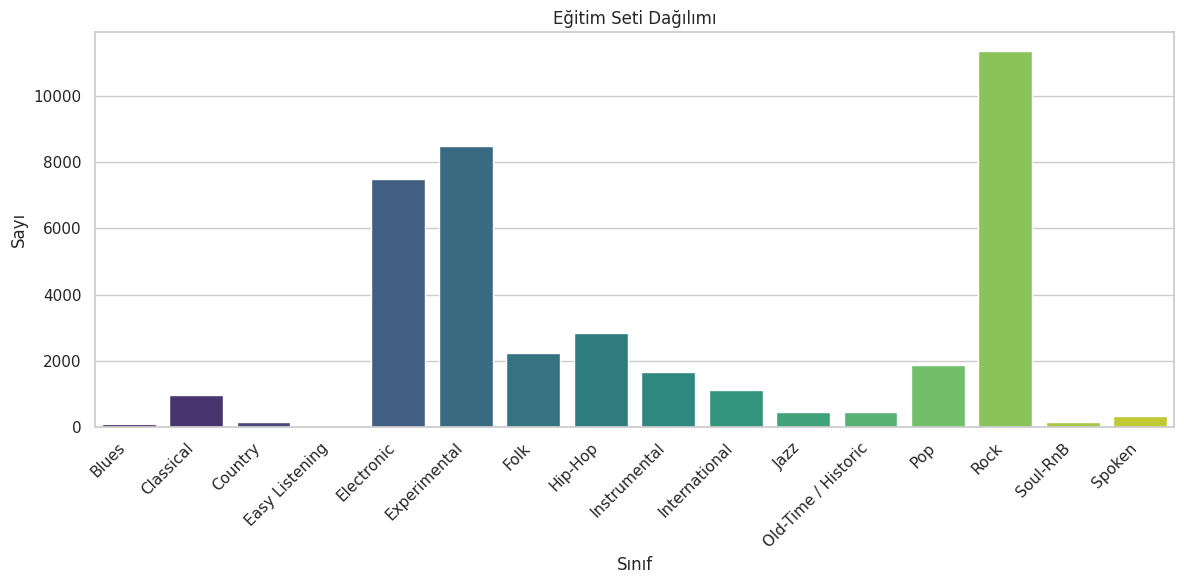

Eğitim/test bölünmesi tamamlandı: X_train (39678, 518), X_test (9920, 518)

Eğitim Seti Dağılımı (ham sayılar):
Sınıf 0 (Blues): 88 örnek
Sınıf 1 (Classical): 984 örnek
Sınıf 2 (Country): 155 örnek
Sınıf 3 (Easy Listening): 19 örnek
Sınıf 4 (Electronic): 7498 örnek
Sınıf 5 (Experimental): 8486 örnek
Sınıf 6 (Folk): 2242 örnek
Sınıf 7 (Hip-Hop): 2842 örnek
Sınıf 8 (Instrumental): 1663 örnek
Sınıf 9 (International): 1111 örnek
Sınıf 10 (Jazz): 457 örnek
Sınıf 11 (Old-Time / Historic): 443 örnek
Sınıf 12 (Pop): 1866 örnek
Sınıf 13 (Rock): 11346 örnek
Sınıf 14 (Soul-RnB): 140 örnek
Sınıf 15 (Spoken): 338 örnek


In [5]:
# Veriyi böl ve eğitim dağılımını göster
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

plot_class_distribution(y_train, le.classes_, 'Eğitim Seti Dağılımı')
print(f'Eğitim/test bölünmesi tamamlandı: X_train {X_train.shape}, X_test {X_test.shape}')

# Detaylı dağılımı yazdır
unique, counts = np.unique(y_train, return_counts=True)
print("\nEğitim Seti Dağılımı (ham sayılar):")
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"Sınıf {u} ({le.classes_[i]}): {c} örnek")

## Veri Dengeleme - Aşama 1

İlk aşamada, çok az örneğe sahip sınıflar için RandomOverSampler kullanılıyor. Bu aşama, BorderlineSMOTE için yeterli örnek sayısına ulaşmamızı sağlar.


Adım 1: Aşırı az temsil edilen sınıflar için RandomOverSampler uygulanıyor...

RandomOverSampler sonrası dağılım (ham sayılar):
Sınıf 0 (Blues): 88 örnek
Sınıf 1 (Classical): 984 örnek
Sınıf 2 (Country): 155 örnek
Sınıf 3 (Easy Listening): 100 örnek
Sınıf 4 (Electronic): 7498 örnek
Sınıf 5 (Experimental): 8486 örnek
Sınıf 6 (Folk): 2242 örnek
Sınıf 7 (Hip-Hop): 2842 örnek
Sınıf 8 (Instrumental): 1663 örnek
Sınıf 9 (International): 1111 örnek
Sınıf 10 (Jazz): 457 örnek
Sınıf 11 (Old-Time / Historic): 443 örnek
Sınıf 12 (Pop): 1866 örnek
Sınıf 13 (Rock): 11346 örnek
Sınıf 14 (Soul-RnB): 140 örnek
Sınıf 15 (Spoken): 338 örnek

RandomOverSampler sonrası dağılım (ham sayılar):
Sınıf 0 (Blues): 88 örnek
Sınıf 1 (Classical): 984 örnek
Sınıf 2 (Country): 155 örnek
Sınıf 3 (Easy Listening): 100 örnek
Sınıf 4 (Electronic): 7498 örnek
Sınıf 5 (Experimental): 8486 örnek
Sınıf 6 (Folk): 2242 örnek
Sınıf 7 (Hip-Hop): 2842 örnek
Sınıf 8 (Instrumental): 1663 örnek
Sınıf 9 (International): 1111 örnek


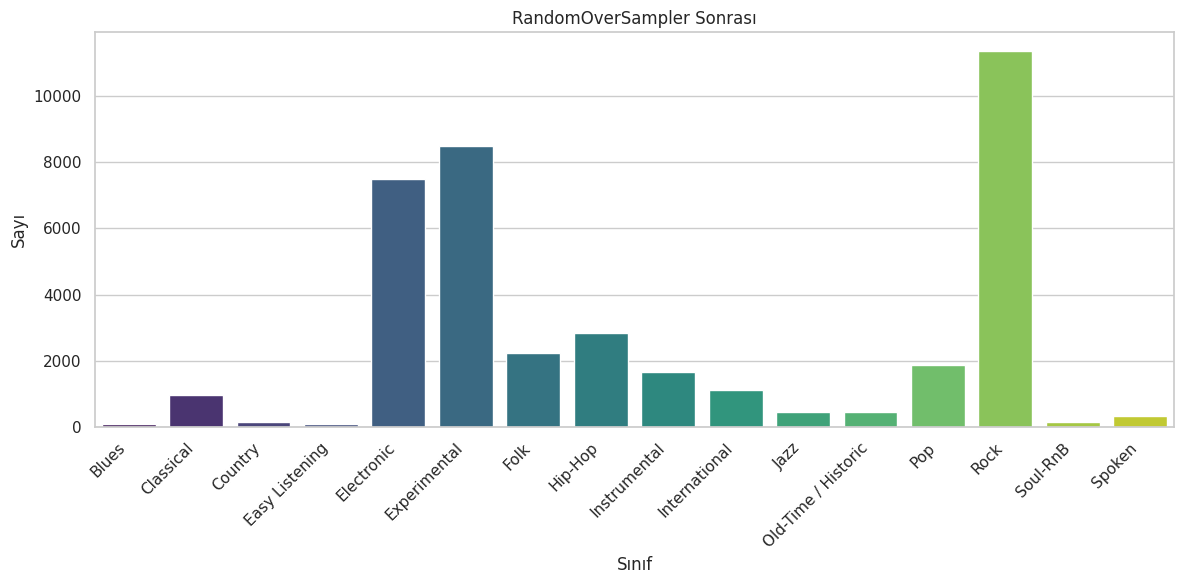

In [6]:
# Adım 1: En az temsil edilen sınıflar için RandomOverSampler
print('\nAdım 1: Aşırı az temsil edilen sınıflar için RandomOverSampler uygulanıyor...')
min_samples_threshold = 100  # BorderlineSMOTE için gereken minimum örnek sayısı
ros = RandomOverSampler(sampling_strategy={3: min_samples_threshold}, random_state=42)
X_partial, y_partial = ros.fit_resample(X_train, y_train)

# Ara sonuçları göster
unique_partial, counts_partial = np.unique(y_partial, return_counts=True)
print("\nRandomOverSampler sonrası dağılım (ham sayılar):")
for i, (u, c) in enumerate(zip(unique_partial, counts_partial)):
    print(f"Sınıf {u} ({le.classes_[i]}): {c} örnek")

plot_class_distribution(y_partial, le.classes_, 'RandomOverSampler Sonrası')

## Veri Dengeleme - Aşama 2

İkinci aşamada, daha sofistike bir yaklaşım olan BorderlineSMOTE kullanılarak kalan sınıflar dengeleniyor. Bu yöntem, sadece rastgele kopyalama yerine sentetik örnekler oluşturur.

Not: Bu aşama, veri setinin yapısına bağlı olarak başarısız olabilir. Bu durumda, ilk aşamadaki sonuçlar kullanılacaktır.


Adım 2: Kalan sınıflar için BorderlineSMOTE uygulanıyor...
Kombine örnekleme tamamlandı: X_res (181536, 518), y_res (181536,)

Son Dağılım (ham sayılar):
Sınıf 0 (Blues): 11346 örnek
Sınıf 1 (Classical): 11346 örnek
Sınıf 2 (Country): 11346 örnek
Sınıf 3 (Easy Listening): 11346 örnek
Sınıf 4 (Electronic): 11346 örnek
Sınıf 5 (Experimental): 11346 örnek
Sınıf 6 (Folk): 11346 örnek
Sınıf 7 (Hip-Hop): 11346 örnek
Sınıf 8 (Instrumental): 11346 örnek
Sınıf 9 (International): 11346 örnek
Sınıf 10 (Jazz): 11346 örnek
Sınıf 11 (Old-Time / Historic): 11346 örnek
Sınıf 12 (Pop): 11346 örnek
Sınıf 13 (Rock): 11346 örnek
Sınıf 14 (Soul-RnB): 11346 örnek
Sınıf 15 (Spoken): 11346 örnek
Kombine örnekleme tamamlandı: X_res (181536, 518), y_res (181536,)

Son Dağılım (ham sayılar):
Sınıf 0 (Blues): 11346 örnek
Sınıf 1 (Classical): 11346 örnek
Sınıf 2 (Country): 11346 örnek
Sınıf 3 (Easy Listening): 11346 örnek
Sınıf 4 (Electronic): 11346 örnek
Sınıf 5 (Experimental): 11346 örnek
Sınıf 6 (Folk): 11346 

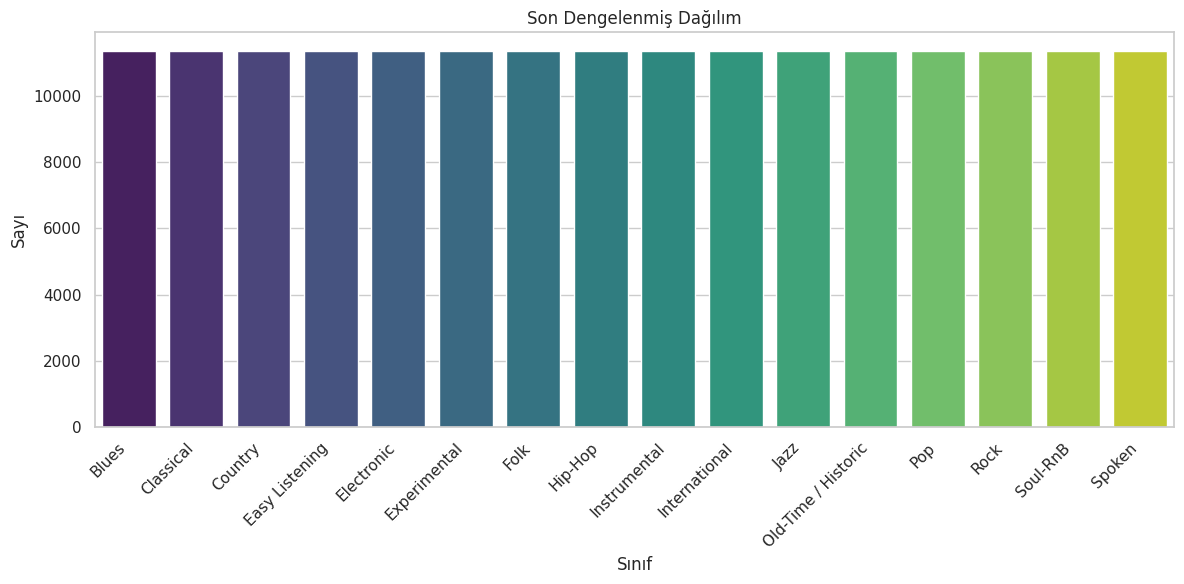


İşlem hattı tamamlandı. Yeniden örneklenmiş eğitim verisi (X_res, y_res) ve test verisi (X_test, y_test) hazır.


In [7]:
# Adım 2: Kalan sınıflar için BorderlineSMOTE
print('\nAdım 2: Kalan sınıflar için BorderlineSMOTE uygulanıyor...')
borderline_smote = BorderlineSMOTE(random_state=42)

try:
    X_res, y_res = borderline_smote.fit_resample(X_partial, y_partial)
    print(f'Kombine örnekleme tamamlandı: X_res {X_res.shape}, y_res {y_res.shape}')
    
    # Son dağılımı yazdır ve göster
    unique_res, counts_res = np.unique(y_res, return_counts=True)
    print("\nSon Dağılım (ham sayılar):")
    for i, (u, c) in enumerate(zip(unique_res, counts_res)):
        print(f"Sınıf {u} ({le.classes_[i]}): {c} örnek")
    
    plot_class_distribution(y_res, le.classes_, 'Son Dengelenmiş Dağılım')

except Exception as e:
    print(f'BorderlineSMOTE örnekleme başarısız oldu: {e} - kısmi örneklenmiş veri kullanılıyor')
    X_res, y_res = X_partial, y_partial
    plot_class_distribution(y_res, le.classes_, 'Kısmi Örnekleme (BorderlineSMOTE başarısız)')

print("\nİşlem hattı tamamlandı. Yeniden örneklenmiş eğitim verisi (X_res, y_res) ve test verisi (X_test, y_test) hazır.")

*-----------------------------------------------------------------------------------*
# PyTorch LSTM MODEL EĞİTİMİ
*-----------------------------------------------------------------------------------*

In [8]:
print("\nPyTorch LSTM Model Eğitimi Başlıyor...")

# Veri yükleme, önişleme, bölme ve dengeleme adımlarının tamamlandığı varsayılır.
# Bu noktada aşağıdaki değişkenlerin mevcut olması beklenir:
# X_res, y_res (Dengelenmiş eğitim verisi)
# X_val, y_val (Doğrulama verisi)
# X_test, y_test (Test verisi)
# le (LabelEncoder nesnesi)


PyTorch LSTM Model Eğitimi Başlıyor...


In [ ]:
# Dengelenmiş veri setinden doğrulama seti ayır
X_train_bal, X_val, y_train_bal, y_val = train_test_split(
    X_res, y_res, test_size=0.1, stratify=y_res, random_state=42
)

# Veri Ölçeklendirme (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Veri ölçeklendirme tamamlandı.")
print(f"Ölçeklenmiş eğitim verisi boyutu: {X_train_scaled.shape}")
print(f"Ölçeklenmiş doğrulama verisi boyutu: {X_val_scaled.shape}")
print(f"Ölçeklenmiş test verisi boyutu: {X_test_scaled.shape}")

Veri ölçeklendirme tamamlandı.
Ölçeklenmiş eğitim verisi boyutu: (163382, 518)
Ölçeklenmiş doğrulama verisi boyutu: (18154, 518)
Ölçeklenmiş test verisi boyutu: (9920, 518)


## LSTM Modeli için Veri Hazırlığı

PyTorch LSTM modeli için, veriyi uygun formata dönüştürmemiz gerekir. LSTM modeller sıralı veri bekler, bu nedenle öznitelik vektörünü zamansal bir diziye dönüştüreceğiz.

In [10]:
# PyTorch tensörlerine dönüştürme ve veri setlerini hazırlama
def create_sequence_data(X, y, sequence_length=10):
    """
    Öznitelik vektörünü sıralı verilere dönüştürür.
    FMA veri seti sıralı yapıda değil, bu nedenle yapay bir sıra oluşturuyoruz.
    """
    # Veri boyutlarını kontrol et
    n_samples, n_features = X.shape
    
    # Veriyi yeniden şekillendirme
    features_per_timestep = n_features // sequence_length
    
    if features_per_timestep == 0:
        features_per_timestep = 1
        sequence_length = min(sequence_length, n_features)
    
    # Son timestep'e sığmayan özellikleri ele alma
    remainder = n_features - (sequence_length * features_per_timestep)
    
    # Yeniden şekillendirilmiş veri için array oluşturma
    X_seq = np.zeros((n_samples, sequence_length, features_per_timestep))
    
    # Veriyi yeniden şekillendirme
    for i in range(n_samples):
        for t in range(sequence_length):
            start_idx = t * features_per_timestep
            end_idx = min(start_idx + features_per_timestep, n_features)
            
            if start_idx < n_features:
                X_seq[i, t, :end_idx-start_idx] = X[i, start_idx:end_idx]
    
    # PyTorch tensörlerine dönüştürme
    X_tensor = torch.FloatTensor(X_seq)
    y_tensor = torch.LongTensor(y)
    
    return X_tensor, y_tensor

# Sıralı veri için hiperparametre
sequence_length = 10

# Ölçeklenmiş verileri sıralı forma dönüştürme
X_train_seq, y_train_tensor = create_sequence_data(X_train_scaled, y_train_bal, sequence_length)
X_val_seq, y_val_tensor = create_sequence_data(X_val_scaled, y_val, sequence_length)
X_test_seq, y_test_tensor = create_sequence_data(X_test_scaled, y_test, sequence_length)

print(f"Eğitim veri boyutu: {X_train_seq.shape}")
print(f"Doğrulama veri boyutu: {X_val_seq.shape}")
print(f"Test veri boyutu: {X_test_seq.shape}")

# PyTorch DataLoader oluşturma
batch_size = 32
train_dataset = TensorDataset(X_train_seq, y_train_tensor)
val_dataset = TensorDataset(X_val_seq, y_val_tensor)
test_dataset = TensorDataset(X_test_seq, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Eğitim veri boyutu: torch.Size([163382, 10, 51])
Doğrulama veri boyutu: torch.Size([18154, 10, 51])
Test veri boyutu: torch.Size([9920, 10, 51])


## LSTM Model Tanımı ve Eğitimi

Aşağıda müzik türü sınıflandırması için bir LSTM (Long Short-Term Memory) ağı tanımlıyoruz. LSTM'ler, müzik gibi sıralı verilerde başarılı olan bir derin öğrenme mimarisidir.

In [11]:
# LSTM model sınıfını tanımlama
class MusicGenreLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(MusicGenreLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM katmanları
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # Dropout katmanı
        self.dropout = nn.Dropout(dropout)
        
        # Tam bağlantılı katmanlar
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Aktivasyon fonksiyonları
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # LSTM katmanından geçirme
        # x şekli: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Son zaman adımının çıktısını al
        # lstm_out şekli: (batch_size, sequence_length, hidden_size)
        lstm_out = lstm_out[:, -1, :]
        
        # Batch normalization
        batch_norm_out = self.batch_norm(lstm_out)
        
        # İlk tam bağlantılı katman
        fc1_out = self.fc1(batch_norm_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout(fc1_out)
        
        # İkinci tam bağlantılı katman (çıkış katmanı)
        out = self.fc2(fc1_out)
        
        return out

# Model parametreleri
input_size = X_train_seq.shape[2]  # Bir zaman adımındaki özellik sayısı
hidden_size = 128  # LSTM gizli durum boyutu
num_layers = 2  # LSTM katman sayısı
num_classes = len(le.classes_)  # Sınıf sayısı
dropout = 0.3  # Dropout oranı

# GPU kullanılabilir mi kontrol et
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

# Model oluşturma
model = MusicGenreLSTM(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
print(model)

# Kayıp fonksiyonu ve optimize edici tanımlama
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Eğitim fonksiyonu
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    # Ölçüm değerlerini saklayacak listeler
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # En iyi doğrulama kaybını ve modeli saklama
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(num_epochs):
        # Eğitim modu
        model.train()
        
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradyanları sıfırla
            optimizer.zero_grad()
            
            # İleri geçiş
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Geri yayılım ve optimize etme
            loss.backward()
            optimizer.step()
            
            # İstatistikleri güncelle
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Doğrulama modu
        model.eval()
        
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # İleri geçiş
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # İstatistikleri güncelle
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Epoch sonuçlarını hesapla
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total
        
        # Öğrenme oranını ayarla
        scheduler.step(epoch_val_loss)
        
        # Sonuçları sakla
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        # Eğitim durumunu yazdır
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        
        # En iyi modeli sakla
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()
    
    # En iyi model ağırlıklarını yükle
    model.load_state_dict(best_model)
    
    return model, train_losses, val_losses, train_accs, val_accs

# Modeli eğit
print("Model eğitimi başlıyor...")
num_epochs = 30
try:
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )
    print("Model eğitimi tamamlandı!")
except KeyboardInterrupt:
    print("Eğitim kullanıcı tarafından durduruldu.")

Kullanılan cihaz: cuda
MusicGenreLSTM(
  (lstm): LSTM(51, 128, num_layers=2, batch_first=True, dropout=0.3)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
MusicGenreLSTM(
  (lstm): LSTM(51, 128, num_layers=2, batch_first=True, dropout=0.3)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
Model eğitimi başlıyor...
Model eğitimi başlıyor...
Epoch 1/30 - Train Loss: 0.7117, Train Acc: 0.7719, Val Loss: 0.4539, Val Acc: 0.8553
Epoch 1/30 - Train Loss: 0.7117, Train Acc: 0.7719, Val Loss: 0.4539, Val Acc: 0.8553
Epoch 2/30 - Train 

## Model Değerlendirmesi ve Görselleştirme

Bu bölümde eğitilmiş modeli test veri seti üzerinde değerlendirip, sonuçları görselleştireceğiz.

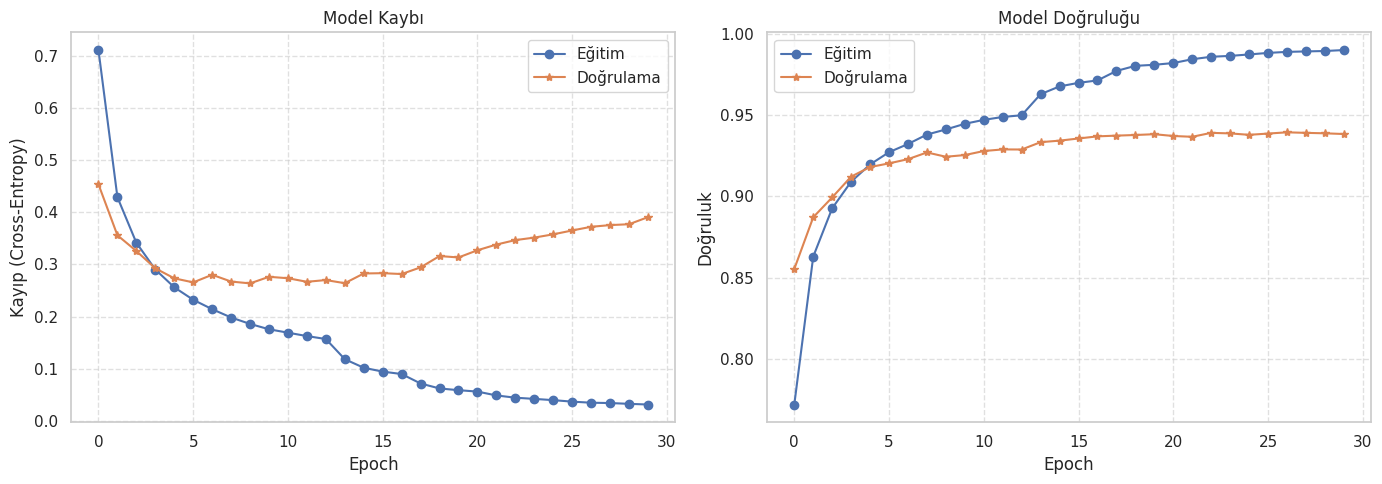

Test Doğruluğu: 0.6301

Sınıflandırma Raporu:
                     precision    recall  f1-score   support

              Blues       0.29      0.09      0.14        22
          Classical       0.79      0.79      0.79       246
            Country       0.69      0.46      0.55        39
     Easy Listening       0.00      0.00      0.00         5
         Electronic       0.60      0.65      0.63      1874
       Experimental       0.61      0.63      0.62      2122
               Folk       0.54      0.56      0.55       561
            Hip-Hop       0.66      0.62      0.64       710
       Instrumental       0.35      0.37      0.36       416
      International       0.58      0.54      0.56       278
               Jazz       0.47      0.35      0.40       114
Old-Time / Historic       0.91      0.89      0.90       111
                Pop       0.25      0.19      0.22       466
               Rock       0.75      0.75      0.75      2836
           Soul-RnB       0.44      0.

/home/debian/pydebian/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/debian/pydebian/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/debian/pydebian/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


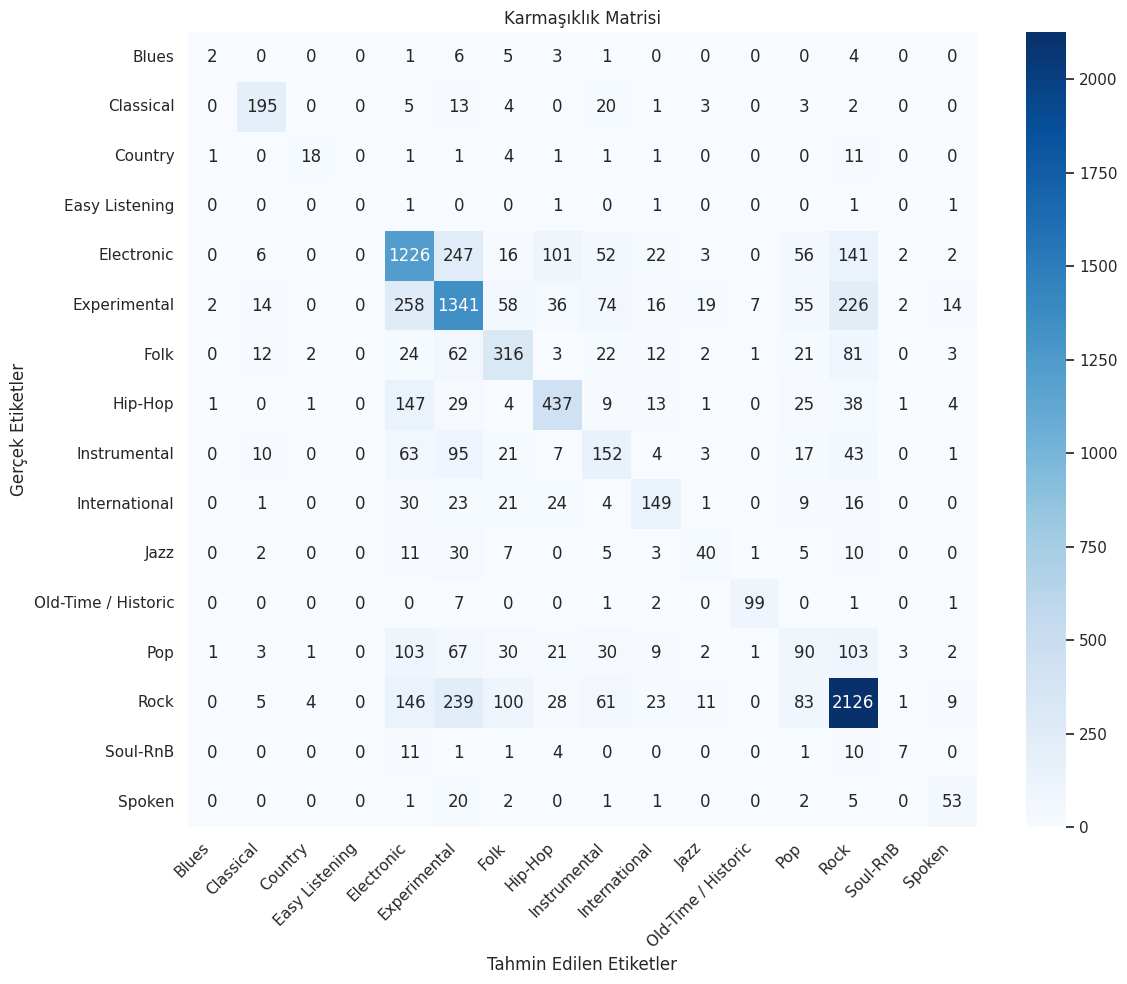

In [12]:
# Eğitim sonuçlarını görselleştirme
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(14, 5))
    
    # Kayıp grafiği
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Eğitim', marker='o')
    plt.plot(val_losses, label='Doğrulama', marker='*')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Cross-Entropy)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Doğruluk grafiği
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Eğitim', marker='o')
    plt.plot(val_accs, label='Doğrulama', marker='*')
    plt.title('Model Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Eğitim sonuçlarını görselleştir
try:
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
except NameError:
    print("Eğitim geçmişi bulunamadı. Önce modeli eğitin.")

# Test veri seti üzerinde değerlendirme
def evaluate_model(model, test_loader, device):
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Doğruluk hesapla
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    
    # Sonuçları yazdır
    print(f"Test Doğruluğu: {accuracy:.4f}")
    
    # Sınıflandırma raporu
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    # Karmaşıklık matrisi
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Karmaşıklık Matrisi')
    plt.xlabel('Tahmin Edilen Etiketler')
    plt.ylabel('Gerçek Etiketler')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

# Test veri seti üzerinde değerlendir
try:
    y_true, y_pred = evaluate_model(model, test_loader, device)
except NameError:
    print("Model bulunamadı. Önce modeli eğitin.")

## Model Değerlendirmesi ve İleriye Dönük Çalışmalar

Müzik türü sınıflandırma modelimiz veriyi dengeledikten sonra eğitilmiştir. Sonuçlar değerlendirilirken şunlar göz önünde bulundurulmalıdır:

1. **Veri Kalitesi**: FMA veri setindeki özellikler, ses dosyalarından çıkarılmış özelliklerdir. Daha iyi sonuçlar için ham ses verileri üzerinde spektrogram analizi yapılabilir.

2. **Model Mimarisi**: LSTM modeli, sıralı verilerde başarılı olmasına rağmen, müzik türü tanıma için CNN (Convolutional Neural Network) veya CNN-LSTM hibrit modeller de kullanılabilir.

3. **Hiperparametreler**: Farklı hiperparametreler (örn. öğrenme oranı, katman sayısı, nöron sayısı) ile model performansı artırılabilir.

4. **Veri Dengeleme**: Kullandığımız veri dengeleme yöntemleri, eğitim setindeki sınıf dağılımını eşitlemeye yardımcı olur, ancak sentetik veri oluşturma riskleri de taşır.

İleriye dönük çalışmalarda, daha karmaşık modeller, farklı özellik çıkarma teknikleri ve daha büyük veri setleri kullanılarak performans artırılabilir.